z Python Module Functions:
- [stft - Short-time Fourier transform (STFT)](#stft)
- [istft - Inverse STFT](#istft)
- [cqtkernel - Constant-Q transform (CQT) kernel](#cqtkernel-constant-q-transform-cqt-kernel-1)
- [cqtspectrogram - CQT spectrogram using a CQT kernel](#cqtspectrogram-constant-q-transform-cqt-spectrogram-using-a-cqt-kernel-1)
- [cqtchromagram - CQT chromagram using a CQT kernel](#cqtchromagram-constant-q-transform-cqt-chromagram-using-a-cqt-kernel-1)
- [mfcc - Mel frequency cepstrum coefficients (MFCCs)](#mfcc-mel-frequency-cepstrum-coefficients-mfccs-1)
- [dct - Discrete cosine transform (DCT) using the fast Fourier transform (FFT)](#dct-discrete-cosine-transform-dct-using-the-fast-fourier-transform-fft-1)
- [dst - Discrete sine transform (DST) using the FFT](#dst-discrete-sine-transform-dst-using-the-fast-fourier-transform-fft-1)
- [mdct - Modified discrete cosine transform (MDCT) using the FFT](#mdct-modified-discrete-cosine-transform-mdct-using-the-fast-fourier-transform-fft)
- [imdct - Inverse MDCT using the FFT](#imdct-inverse-modified-discrete-cosine-transform-mdct-using-the-fast-fourier-transform-fft)

# <a id="stft"></a>stft Short-time Fourier transform (STFT)

Arguments:

Example: Compute and display the spectrogram of an audio file

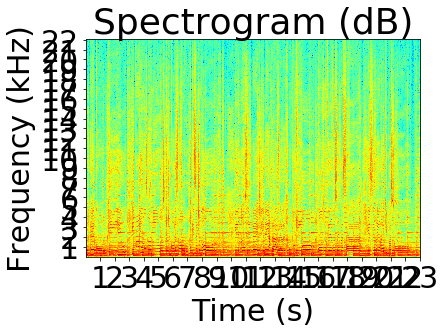

In [10]:
# Import modules
import scipy.io.wavfile
import numpy as np
import scipy.signal
import z
import matplotlib.pyplot as plt

# Audio signal (normalized) averaged over its channels and sample rate in Hz
sample_rate, audio_signal = scipy.io.wavfile.read('audio_file.wav')
audio_signal = audio_signal/(2.0**(audio_signal.itemsize*8-1))
audio_signal = np.mean(audio_signal, 1)

# Window duration in seconds (audio is stationary around 40 milliseconds)
window_duration = 0.04

# Window length in samples (power of 2 for fast FFT and constant overlap-add (COLA))
window_length = int(np.power(2, np.ceil(np.log2(window_duration * sample_rate))))

# Window function (periodic Hamming window for COLA)
window_function = scipy.signal.hamming(window_length, False)

# Step length in samples (half the window length for COLA)
step_length = int(window_length/2)

# Magnitude spectrogram (without the DC component and the mirrored frequencies)
audio_stft = z.stft(audio_signal, window_function, step_length)
audio_spectrogram = np.absolute(audio_stft[1:int(window_length/2+1), :])

# Spectrogram displayed in dB, s, and kHz
plt.rc('font', size=30)
plt.imshow(20*np.log10(audio_spectrogram), aspect='auto', cmap='jet', origin='lower')
plt.title('Spectrogram (dB)')
plt.xticks(np.round(np.arange(1, np.floor(len(audio_signal)/sample_rate)+1)*sample_rate/step_length),
           np.arange(1, int(np.floor(len(audio_signal)/sample_rate))+1))
plt.xlabel('Time (s)')
plt.yticks(np.round(np.arange(1e3, sample_rate/2+1, 1e3)/sample_rate*window_length),
           np.arange(1, int(sample_rate/2*1e3)+1))
plt.ylabel('Frequency (kHz)')
plt.show()

# <a id="istft"></a>istft Inverse short-time Fourier transform (STFT)

Arguments:

Example: Estimate the center and sides signals of a stereo audio file

In [13]:
# Import modules
import scipy.io.wavfile
import numpy as np
import scipy.signal
import z

# Stereo audio signal (normalized) and sample rate in Hz
sample_rate, audio_signal = scipy.io.wavfile.read('audio_file.wav')
audio_signal = audio_signal / (2.0**(audio_signal.itemsize*8-1))

# Parameters for the STFT
window_duration = 0.04
window_length = int(2**np.ceil(np.log2(window_duration*sample_rate)))
window_function = scipy.signal.hamming(window_length, False)
step_length = int(window_length/2)

# STFT of the left and right channels
audio_stft1 = z.stft(audio_signal[:, 0], window_function, step_length)
audio_stft2 = z.stft(audio_signal[:, 1], window_function, step_length)

# Magnitude spectrogram (with DC component) of the left and right channels
audio_spectrogram1 = abs(audio_stft1[0:int(window_length/2)+1, :])
audio_spectrogram2 = abs(audio_stft2[0:int(window_length/2)+1, :])

# Time-frequency masks of the left and right channels for the center signal
center_mask1 = np.minimum(audio_spectrogram1, audio_spectrogram2)/audio_spectrogram1
center_mask2 = np.minimum(audio_spectrogram1, audio_spectrogram2)/audio_spectrogram2

# STFT of the left and right channels for the center signal (with extension to mirrored frequencies)
center_stft1 = np.multiply(np.concatenate((center_mask1, center_mask1[int(window_length/2)-1:0:-1, :])),
                           audio_stft1)
center_stft2 = np.multiply(np.concatenate((center_mask2, center_mask2[int(window_length/2)-1:0:-1, :])),
                           audio_stft2)

# Synthesized signals of the left and right channels for the center signal
center_signal1 = z.istft(center_stft1, window_function, step_length)
center_signal2 = z.istft(center_stft2, window_function, step_length)

# Final stereo center and sides signals
center_signal = np.stack((center_signal1, center_signal2), 1)
center_signal = center_signal[0:len(audio_signal), :]
sides_signal = audio_signal-center_signal

# Synthesized center and side signals (un-normalized)
scipy.io.wavfile.write('center_signal.wav', sample_rate, center_signal)
scipy.io.wavfile.write('sides_signal.wav', sample_rate, sides_signal)